In [2]:
from sleep_analysis.datasets.d04_main_dataset import D04MainStudy
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing

In [3]:
from empkins_io.sync import SyncedDataset

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [4]:
from biopsykit.signals.ecg import EcgProcessor

In [5]:
from empkins_micro.emrad.radar import get_rpeaks, get_peak_probabilities

In [6]:
from fau_colors import cmaps, register_fausans_font

In [7]:
%matplotlib widget

In [8]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [9]:
### General Settings
id = 4

# General Radar Settings
fs_radar = 1953.125

In [10]:
dataset = D04MainStudy()

In [11]:
dataset

,subj_id
0,01
1,02
2,03
3,04
4,05
5,06
6,07
7,08
8,09
9,10


In [12]:
radar_data = dataset[id].radar_data.data_as_df(index='local_datetime', add_sync_out=True)
synced_radar = dataset[id].sync_radar(radar_data)

Prepare SyncedDataset
Sync beginning of m-sequence


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


-10


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


32


/Users/danielkrauss/code/Empkins/empkins-io/empkins_io/sync/_sync.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_secondary.loc[:, sync_channel_secondary] = self._binarize_signal(


27
Find shift at the end of the m-sequence
Shift: radar_2_aligned_ 563
Shift: radar_3_aligned_ 243
Shift: radar_4_aligned_ 45
Resample sample-wise to get equal length
shortest:75774917
75774917
75775480
75775160
75774962


In [13]:
synced_radar_1 = synced_radar["radar_1_resampled_"]

In [14]:
synced_radar_1

channel,I,Q,Sync_Out
date (Europe/Berlin),,,
2023-04-18 21:27:52.030208+02:00,-3995733,-4321192,1.0
2023-04-18 21:27:52.030720+02:00,-3995906,-4320410,1.0
2023-04-18 21:27:52.031232+02:00,-3996470,-4320618,1.0
2023-04-18 21:27:52.031744+02:00,-3996244,-4320507,1.0
2023-04-18 21:27:52.032256+02:00,-3996083,-4320709,1.0
...,...,...,...
2023-04-19 08:14:28.785152+02:00,-3082785,-4136227,0.0
2023-04-19 08:14:28.785664+02:00,-3082687,-4137108,0.0
2023-04-19 08:14:28.786176+02:00,-3082902,-4136688,0.0


In [15]:
def moving_average(df, window_size, channel):
    """
    Apply a moving average filter to a specified channel in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing signal data.
    - window_size (int): Size of the moving average window.
    - channel (str): The key representing the channel in the DataFrame.

    Returns:
    - pd.DataFrame: DataFrame containing the original data and the moving average in the 'MA' column.

    Notes:
    - Applies a moving average filter to the specified channel in the DataFrame.
    - The first and last values are padded to handle edge effects.
    - The resulting moving average values are stored in a new column named 'MA' in the original DataFrame.
    """

    if channel not in df.columns:
        raise ValueError(f"Channel '{channel}' not found in the DataFrame.")

    first_avg = int(df[channel].iloc[:window_size // 2].mean())

    last_avg = int(df[channel].iloc[-window_size // 2:].mean())

    pad_array = np.array(df[channel])

    padded = np.pad(array=pad_array, pad_width=(window_size // 2), mode='constant',
                    constant_values=(first_avg, last_avg))

    df.loc[:, 'MA'] = padded[window_size // 2:len(padded) - window_size // 2]
    df['MA'] = df['MA'].rolling(window=window_size, center=True, min_periods=1).mean()

    return df

In [16]:
ma_df = moving_average(synced_radar_1, 19000, "I")

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_96541/3662122734.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'MA'] = padded[window_size // 2:len(padded) - window_size // 2]
/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_96541/3662122734.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['MA'].rolling(window=window_size, center=True, min_periods=1).mean()


In [17]:
x = ma_df[["MA"]].values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)


In [18]:
x_scaled_df = pd.DataFrame(x_scaled, index=ma_df.index, columns=["MA_scaled"])
ma_df = pd.concat([ma_df, x_scaled_df], axis=1) 


In [19]:
ma_df

,I,Q,Sync_Out,MA,MA_scaled
date (Europe/Berlin),,,,,
2023-04-18 21:27:52.030208+02:00,-3995733,-4321192,1.0,-3.998452e+06,-2.544840
2023-04-18 21:27:52.030720+02:00,-3995906,-4320410,1.0,-3.998453e+06,-2.544840
2023-04-18 21:27:52.031232+02:00,-3996470,-4320618,1.0,-3.998453e+06,-2.544841
2023-04-18 21:27:52.031744+02:00,-3996244,-4320507,1.0,-3.998453e+06,-2.544842
2023-04-18 21:27:52.032256+02:00,-3996083,-4320709,1.0,-3.998453e+06,-2.544842
...,...,...,...,...,...
2023-04-19 08:14:28.785152+02:00,-3082785,-4136227,0.0,-3.082941e+06,0.311696
2023-04-19 08:14:28.785664+02:00,-3082687,-4137108,0.0,-3.082941e+06,0.311696
2023-04-19 08:14:28.786176+02:00,-3082902,-4136688,0.0,-3.082941e+06,0.311696


In [20]:
#fig, ax = plt.subplots(2, sharex=True)
#ax[0].plot(ma_df["I"])
#ax[0].plot(ma_df["MA"])
#ax[1].plot#(ma_df["MA_scaled"])
#plt.show(#)

In [21]:
def first_order_derivative(df, channel):
    """
    Calculate the first-order derivative of a specified channel in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing signal data.
    - channel (str): The key representing the channel for which the derivative is calculated.

    Returns:
    - pd.DataFrame: DataFrame containing the original data and the calculated first-order derivative.

    Notes:
    - Calculates the first-order derivative of the specified channel using the pandas differentiate_signal function.
    - The absolute values of the derivative are stored in a new column named 'FOD' in the original DataFrame.

    Raises:
    - ValueError: If the specified channel is not found in the DataFrame.
    """
    # Check if the specified channel exists in the DataFrame
    if channel not in df.columns:
        raise ValueError(f"Channel '{channel}' not found in the DataFrame.")

    signal = df[channel]

    derivative = signal.diff()

    df.loc[:, 'FOD'] = derivative.abs()

    return df


In [22]:
fod_df = first_order_derivative(ma_df, "MA_scaled")

In [23]:
fod_df

,I,Q,Sync_Out,MA,MA_scaled,FOD
date (Europe/Berlin),,,,,,
2023-04-18 21:27:52.030208+02:00,-3995733,-4321192,1.0,-3.998452e+06,-2.544840,NaN
2023-04-18 21:27:52.030720+02:00,-3995906,-4320410,1.0,-3.998453e+06,-2.544840,6.586136e-07
2023-04-18 21:27:52.031232+02:00,-3996470,-4320618,1.0,-3.998453e+06,-2.544841,6.581466e-07
2023-04-18 21:27:52.031744+02:00,-3996244,-4320507,1.0,-3.998453e+06,-2.544842,5.059897e-07
2023-04-18 21:27:52.032256+02:00,-3996083,-4320709,1.0,-3.998453e+06,-2.544842,4.556534e-07
...,...,...,...,...,...,...
2023-04-19 08:14:28.785152+02:00,-3082785,-4136227,0.0,-3.082941e+06,0.311696,3.629447e-08
2023-04-19 08:14:28.785664+02:00,-3082687,-4137108,0.0,-3.082941e+06,0.311696,2.377662e-08
2023-04-19 08:14:28.786176+02:00,-3082902,-4136688,0.0,-3.082941e+06,0.311696,9.437335e-08


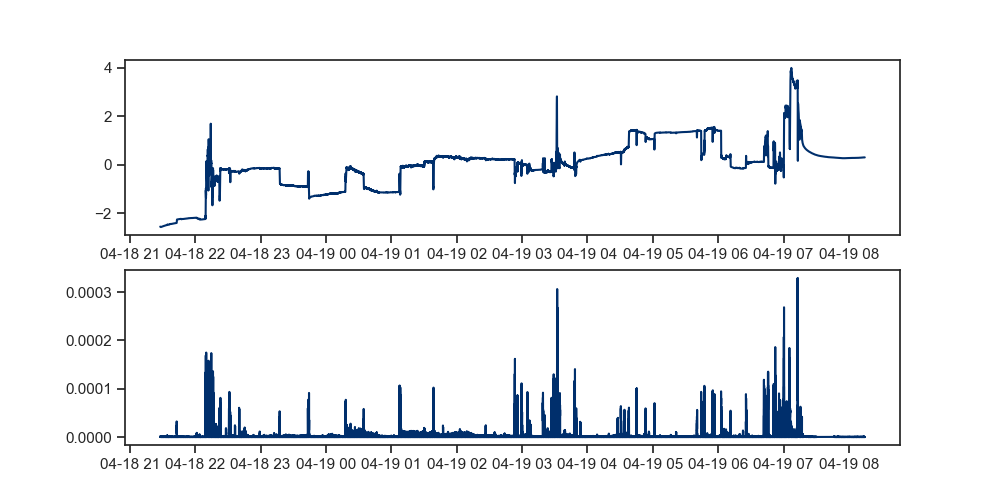

In [24]:
fig, ax = plt.subplots(2)
ax[0].plot(fod_df["MA_scaled"])
ax[1].plot(fod_df["FOD"])
plt.show()

In [25]:
def normalize(df, channel):
    """adjusts the amplitude of the signal, so that the max is at 1 and the rest between 0 and 1"""
    min_val = df[channel].min()
    max_val = df[channel].max()
    df["NORM"] = (df[channel] - min_val) / (max_val - min_val)
    return df


In [26]:
norm_df = normalize(fod_df, "FOD")

In [27]:
norm_df

,I,Q,Sync_Out,MA,MA_scaled,FOD,NORM
date (Europe/Berlin),,,,,,,
2023-04-18 21:27:52.030208+02:00,-3995733,-4321192,1.0,-3.998452e+06,-2.544840,NaN,NaN
2023-04-18 21:27:52.030720+02:00,-3995906,-4320410,1.0,-3.998453e+06,-2.544840,6.586136e-07,0.002000
2023-04-18 21:27:52.031232+02:00,-3996470,-4320618,1.0,-3.998453e+06,-2.544841,6.581466e-07,0.001999
2023-04-18 21:27:52.031744+02:00,-3996244,-4320507,1.0,-3.998453e+06,-2.544842,5.059897e-07,0.001537
2023-04-18 21:27:52.032256+02:00,-3996083,-4320709,1.0,-3.998453e+06,-2.544842,4.556534e-07,0.001384
...,...,...,...,...,...,...,...
2023-04-19 08:14:28.785152+02:00,-3082785,-4136227,0.0,-3.082941e+06,0.311696,3.629447e-08,0.000110
2023-04-19 08:14:28.785664+02:00,-3082687,-4137108,0.0,-3.082941e+06,0.311696,2.377662e-08,0.000072
2023-04-19 08:14:28.786176+02:00,-3082902,-4136688,0.0,-3.082941e+06,0.311696,9.437335e-08,0.000287


In [28]:
def threshold(df, channel, threshold=0.2):
    """
    Applies a threshold to a specific column ('key') in the DataFrame ('df').

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - key (str): Column in the DataFrame to be thresholded.
    - threshold (float): Threshold value.

    Returns:
    - pd.DataFrame: DataFrame with threshold applied.
    """
    df["threshold"] = df[channel].where(df[channel] > threshold, 0.0)

    return df


In [29]:
threshold_df = threshold(norm_df, "NORM", threshold=0.2)

In [30]:
#fig, ax = plt.subplots()
#ax.plot(threshold_df["threshold"])
#plt.show()

In [31]:
def group_30s(df, channel):
    df['grouped'] = df[channel].copy()
    df.index = df.index.floor("30s")
    df = df.groupby(pd.Grouper(freq='30s', origin='epoch')).mean()

    return df

In [32]:
epoch_df = group_30s(fod_df, "threshold")

In [33]:
epoch_df

,I,Q,Sync_Out,MA,MA_scaled,FOD,NORM,threshold,grouped
date (Europe/Berlin),,,,,,,,,
2023-04-18 21:27:30+02:00,-3.999496e+06,-4.319901e+06,0.516960,-3.999860e+06,-2.549230,6.186062e-07,0.001879,0.0,0.0
2023-04-18 21:28:00+02:00,-4.003688e+06,-4.317149e+06,0.513363,-4.003637e+06,-2.561015,1.830686e-07,0.000556,0.0,0.0
2023-04-18 21:28:30+02:00,-4.002936e+06,-4.312521e+06,0.521623,-4.002930e+06,-2.558812,1.382234e-07,0.000420,0.0,0.0
2023-04-18 21:29:00+02:00,-4.000259e+06,-4.307872e+06,0.504915,-4.000255e+06,-2.550465,1.361331e-07,0.000413,0.0,0.0
2023-04-18 21:29:30+02:00,-3.997637e+06,-4.303242e+06,0.513270,-3.997639e+06,-2.542301,1.526799e-07,0.000464,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-04-19 08:12:00+02:00,-3.084842e+06,-4.135386e+06,0.455576,-3.084853e+06,0.305733,8.303936e-08,0.000252,0.0,0.0
2023-04-19 08:12:30+02:00,-3.084104e+06,-4.135644e+06,0.501126,-3.084104e+06,0.308070,6.087343e-08,0.000185,0.0,0.0
2023-04-19 08:13:00+02:00,-3.083645e+06,-4.135932e+06,0.532205,-3.083636e+06,0.309530,8.299504e-08,0.000252,0.0,0.0


In [34]:
actigraphy = dataset[id].activity_data.data_as_df(index='local_datetime')


Extracting EDF parameters from /Users/danielkrauss/code/Empkins/Data/empkins_contactless_sleep_lab/Vp_05/psg/Vp_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [35]:
actigraphy.index = actigraphy.index.floor("30s")
actigraphy = actigraphy.groupby(pd.Grouper(freq='30s', origin='epoch')).mean()
actigraphy = threshold(actigraphy, channel="Activity", threshold=0.05)
actigraphy = normalize(actigraphy, channel="threshold")
actigraphy


,Activity,threshold,NORM
date (Europe/Berlin),,,
2023-04-18 21:59:00+02:00,16.200077,16.200077,0.094595
2023-04-18 21:59:30+02:00,10.552207,10.552207,0.061616
2023-04-18 22:00:00+02:00,0.878696,0.878696,0.005131
2023-04-18 22:00:30+02:00,7.226561,7.226561,0.042197
2023-04-18 22:01:00+02:00,14.310501,14.310501,0.083562
...,...,...,...
2023-04-19 06:56:00+02:00,2.191764,2.191764,0.012798
2023-04-19 06:56:30+02:00,8.704073,8.704073,0.050825
2023-04-19 06:57:00+02:00,7.847583,7.847583,0.045823


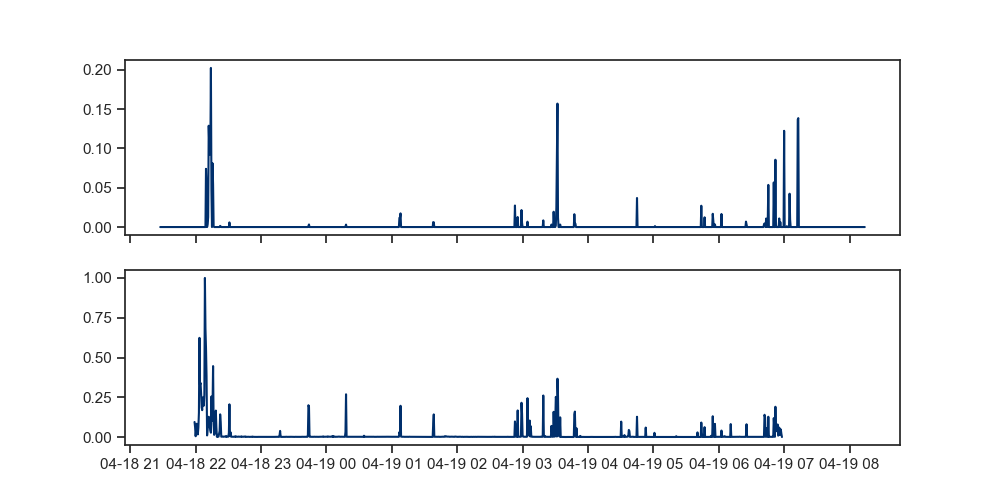

In [36]:
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(epoch_df["grouped"])
ax[1].plot(actigraphy["NORM"])
plt.show()